<a href="https://www.kaggle.com/code/yussufkadir/sales-forecast?scriptVersionId=223058039" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# 1. Importing Libraries that is going to be used for the data preprocessing and visualizing.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA

# 2. Data exploration and preprocessing.

In [3]:
submission_sample = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")
submission_sample.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


#### This cell is suggesting that target is sales column.

#### Data needs to be read first and we will parse the dates when the data contains date because we need to ensure that data is in date time format. 

### 2.2 Turning all data into one piece.

In [4]:
train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv", parse_dates=['date'])
test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv", parse_dates=['date'])
holiday_events = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv", parse_dates=['date'])
transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv", parse_dates=['date'])
stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv", parse_dates=['date'])

In [5]:
df = train.merge(stores, on='store_nbr', how='left')
df = df.merge(oil, on='date', how='left')

holiday_events['is_holiday'] = 1
holiday_events = holiday_events[['date','is_holiday']].drop_duplicates(subset='date')

df = df.merge(holiday_events, on='date', how='left')

df = df.merge(transactions, on=['date', 'store_nbr'], how='left')

df.fillna(0, inplace=True)
df.set_index('date', inplace=True)

df.head()

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,is_holiday,transactions
date,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0
2013-01-01,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0
2013-01-01,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0
2013-01-01,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0
2013-01-01,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0


In [6]:
df['weekdays'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

df['is_weekend'] = (df.index.dayofweek > 5).astype(int)
df.head()

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,is_holiday,transactions,weekdays,month,year,is_weekend
date,,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0,1,1,2013,0
2013-01-01,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0,1,1,2013,0
2013-01-01,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0,1,1,2013,0
2013-01-01,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0,1,1,2013,0
2013-01-01,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0.0,1.0,0.0,1,1,2013,0


In [7]:
label_encoder = LabelEncoder()
label_encoded_cols = ['family','city','state','type']
df['family'] = label_encoder.fit_transform(df['family'])
df['city'] = label_encoder.fit_transform(df['city'])
df['state'] = label_encoder.fit_transform(df['state'])
df['type'] = label_encoder.fit_transform(df['type'])

df.head()

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,is_holiday,transactions,weekdays,month,year,is_weekend
date,,,,,,,,,,,,,,,,
2013-01-01,0,1,0,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0
2013-01-01,1,1,1,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0
2013-01-01,2,1,2,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0
2013-01-01,3,1,3,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0
2013-01-01,4,1,4,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0


In [8]:
df['lag_7'] = df['sales'].shift(7)
df['window_7_mean'] = df['sales'].rolling(window=7).mean()
df.fillna(0, inplace=True)
df.head()

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,is_holiday,transactions,weekdays,month,year,is_weekend,lag_7,window_7_mean
date,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,0,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0
2013-01-01,1,1,1,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0
2013-01-01,2,1,2,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0
2013-01-01,3,1,3,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0
2013-01-01,4,1,4,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0


In [9]:
split_date = '2017-01-01'
train_df = df[:split_date]
test_df = df[split_date:]

In [10]:
model = ARIMA(train_df['sales'], order=(7,1,1))

model_fitting = model.fit()

print(model_fitting.summary())

predictions = model_fitting.forecast(steps=len(test_df))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:              2598156
Model:                 ARIMA(7, 1, 1)   Log Likelihood           -21692297.112
Date:                Mon, 17 Feb 2025   AIC                       43384612.224
Time:                        18:45:58   BIC                       43384727.157
Sample:                             0   HQIC                      43384642.691
                            - 2598156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0710      0.001   -115.243      0.000      -0.072      -0.070
ar.L2         -0.0087      0.001    -11.476      0.000      -0.010      -0.007
ar.L3         -0.0540      0.001    -55.222      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


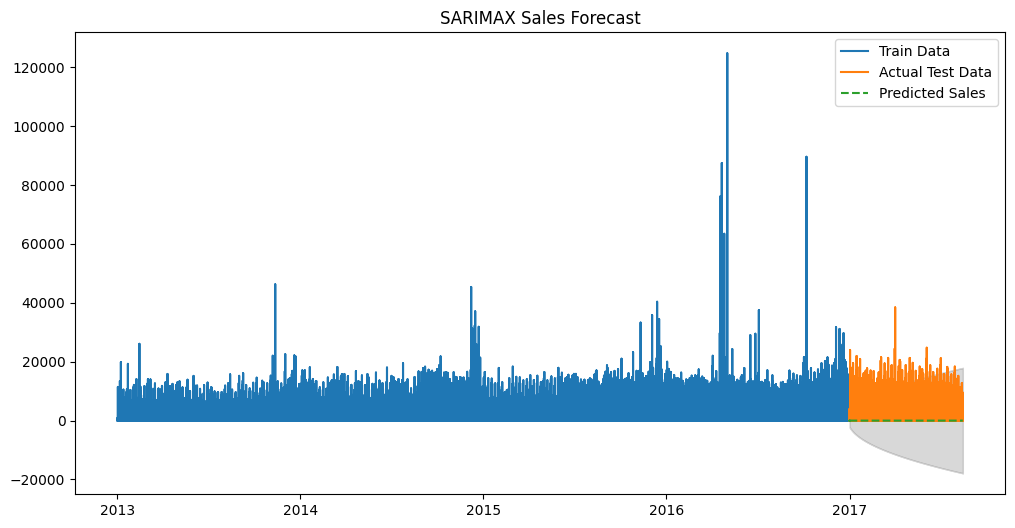

In [11]:
forecast_steps = len(test_df)
forecast = model_fitting.get_forecast(steps=forecast_steps, exog=test_df.drop('sales', axis=1))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(train_df.index, train_df['sales'], label='Train Data')
plt.plot(test_df.index, test_df['sales'], label='Actual Test Data')
plt.plot(test_df.index, forecast_mean, label='Predicted Sales', linestyle='dashed')
plt.fill_between(test_df.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.title("SARIMAX Sales Forecast")
plt.show()

In [12]:
df.head()

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,is_holiday,transactions,weekdays,month,year,is_weekend,lag_7,window_7_mean
date,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,0,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0
2013-01-01,1,1,1,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0
2013-01-01,2,1,2,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0
2013-01-01,3,1,3,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0
2013-01-01,4,1,4,0.0,0,18,12,3,13,0.0,1.0,0.0,1,1,2013,0,0.0,0.0


In [13]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
